# Introduction
This notebook is based on 
1. [2.5d segmentaion baseline [training]](https://www.kaggle.com/code/tanakar/2-5d-segmentaion-baseline-training)
2. [2.5d segmentaion baseline [inference]](https://www.kaggle.com/code/tanakar/2-5d-segmentaion-baseline-inference)
3. [Vesuvius Challenge - 3D ResNet Training](https://www.kaggle.com/code/samfc10/vesuvius-challenge-3d-resnet-training)
4. [Improving performance with L1/Hessian denoising](https://www.kaggle.com/code/brettolsen/improving-performance-with-l1-hessian-denoising)

Thank them for letting us learn more.(^w^)

Base parameter:
1. ResNet34
2. 1fold only!! (Use 2,3 to train and 1 to val)
3. use 16 channels
4. loss = 0.5 * BCELoss + 0.5 * DiceLoss

then get cv0.55 (^w^)


In [100]:
import os,cv2
import gc
import sys
import random
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

ROOT_DIR = "/home/fummicc1/codes/competitions/kaggle-ink-detection"

sys.path.append(ROOT_DIR)
# sys.path.append("/kaggle/input/resnet3d")
from resnet3d import generate_model
import torch as tc


def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [101]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    comp_dir_path = '/home/fummicc1/codes/competitions/kaggle-ink-detection'
    # comp_dir_path = '/home/fummicc1/codes/Kaggle/kaggle-ink-detection/'    
    # comp_dir_path = '/kaggle/input/'
    comp_folder_name = ''
    # comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    #backbone = 'efficientnet-b5'
    #backbone = 'mit_b5'
    backbone = 'resnet3d'
    #backbone = 'resnext50_32x4d'
    pretrained = True

    in_chans = 24 # 65
    # ============== training cfg =============
    prd_size=256
    stride = prd_size // 4

    batch_size = 32 # 32
    use_amp = True

    seed = 42
    num_workers=8
    
    mode = "train"

    device_ids=[0, 1, 2, 3]


    TH = 0.3
    exp = 1e-6
    model_depth = 34
    TTA = True

## helper

In [102]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
def normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,f2,...)"""
    #[batch,f1,f2]->dim[1,2]
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    return (x-mean)/(std+1e-9)

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

In [103]:
set_seed(CFG.seed)

In [104]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
def normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,f2,...)"""
    #[batch,f1,f2]->dim[1,2]
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    return (x-mean)/(std+1e-9)

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

## dataset

In [105]:
def read_image(mode, fragment_id):
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        image = cv2.imread(CFG.comp_dataset_path + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.prd_size - image.shape[0] % CFG.prd_size)
        pad1 = (CFG.prd_size - image.shape[1] % CFG.prd_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)
    
    return images

In [106]:
class CustomDataset(Dataset):
    def __init__(self, images, cfg,xys, labels=None, transform: bool = False):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.xys=xys
        self.transform = transform

    def __len__(self):
        # return len(self.xyxys)
        return len(self.images)

    def __getitem__(self, idx):
        location = np.array(self.xys[idx])
        image: np.ndarray = self.images[idx]
        mean = [
            14356.52181557, 14520.70614609, 14744.43771524, 15033.27008516,
        15378.83713455, 15754.16016986, 16109.72300626, 16369.52307949,
        16438.31554409, 16222.07887619, 15666.64744985, 14798.68459147,
        13742.24110022, 12686.91996523, 11817.69218949, 11249.06236971,
        11000.9214373 , 11017.81404872, 11208.47682255, 11483.19329296,
        11775.4475447 , 12046.20032748, 12277.60994428, 12465.5635714
        ]
        mean = np.array(mean) / 255
        std = [
            2114.49032441, 2139.82500352, 2178.50033502, 2233.26290293,
        2302.01975169, 2376.20206417, 2441.80821036, 2483.70993246,
        2488.44506847, 2445.05180237, 2346.44990857, 2193.31216295,
        2006.46319592, 1840.02783395, 1753.62156347, 1741.95262973,
        1741.04684181, 1719.55030132, 1695.41639142, 1688.92260226,
        1702.2708261 , 1728.33221695, 1758.95367666, 1789.17381258
        ]
        std = np.array(std) / 255
        image = (image - mean) / std
        image = np.transpose(image, (2, 0, 1))
        return image, location
        

In [107]:
def make_dataset(fragment_id, is_train_data):
    images = read_image(CFG.mode, fragment_id)
    mask_path = os.path.join(CFG.comp_dataset_path, f"{CFG.mode}/{fragment_id}/mask.png")
    label_path = os.path.join(CFG.comp_dataset_path, f"{CFG.mode}/{fragment_id}/inklabels.png")
    if os.path.exists(label_path):
        labels = cv2.imread(label_path, 0) / 255
    else:
        labels = None
    mask = cv2.imread(mask_path, 0) / 255
    pad0 = (CFG.prd_size - mask.shape[0] % CFG.prd_size)
    pad1 = (CFG.prd_size - mask.shape[1] % CFG.prd_size)

    if labels is not None:
        labels = np.pad(labels, [(0, pad0), (0, pad1)], constant_values=0)
    
    x1_list = list(range(0, images.shape[1]-CFG.prd_size+1, CFG.stride))
    y1_list = list(range(0, images.shape[0]-CFG.prd_size+1, CFG.stride))
    
    images_list = []
    labels_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.prd_size
            x2 = x1 + CFG.prd_size
            if np.all(images[y1:y2, x1:x2]==0):
                continue
            if labels is not None:
                labels_list.append(labels[y1:y2, x1:x2])
            images_list.append(images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    print("hello")
    xyxys = np.stack(xyxys)

    ds = CustomDataset(images_list, CFG,xys=xyxys, labels=labels_list if labels_list else None, transform=is_train_data)
    
    loader = DataLoader(
        ds,
        batch_size=CFG.batch_size,
        shuffle=is_train_data,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True
    )
    
    return loader, xyxys

## 3D ResNet

In [108]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask
    
class SegModel(nn.Module):
    def __init__(self,model_depth=CFG.model_depth):
        super().__init__()
        self.encoder = generate_model(model_depth=CFG.model_depth, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        if x.ndim==4:
            x=x[:,None] # チャネルを追加
        
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))
        
   
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder=SegModel()

    def forward(self, images:torch.Tensor):
        #image.shape=(b,C,H,W)
        if images.ndim==4:
            images=images[:,None]
        # images=normalization(images)
        output = self.encoder(images)
        return output

In [109]:
tc = torch
def TTA(x:tc.Tensor,model:nn.Module):
    #x.shape=(batch,c,h,w)
    shape=x.shape
    x=[x,*[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(1,4)]]
    x=tc.cat(x,dim=0)
    x=model(x)
    x=torch.sigmoid(x)
    x=x.reshape(4,shape[0], 1 ,*shape[2:])
    x=[tc.rot90(x[i],k=4-i,dims=(-2,-1)) for i in range(4)]
    x=tc.stack(x,dim=0)
    return x.mean(0)

In [110]:
#in_submission=get_folder_size("/kaggle/input/vesuvius-challenge-ink-detection/test")!=6732244267
in_submission=True
IS_DEBUG = False
CFG.mode = 'train' if IS_DEBUG else 'test'

TH = CFG.TH
if CFG.mode == 'test':
    fragment_ids = sorted(os.listdir(CFG.comp_dataset_path + CFG.mode))
else:
    fragment_ids = [1]

predictions_map = None
predictions_map_counts = None
pad0 = None
pad1 = None
ori_h = None
ori_w = None

100%|██████████| 24/24 [00:00<00:00, 43.07it/s]


hello


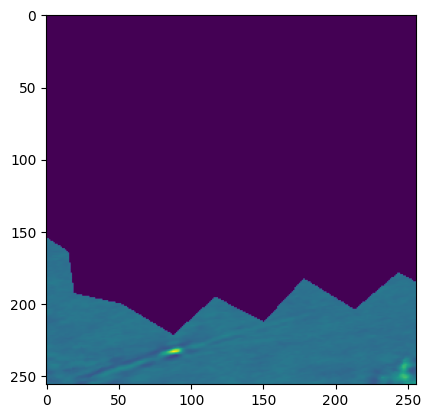

In [111]:
lodaer, _ = make_dataset(3 if IS_DEBUG else "a", is_train_data=False)
img, _ = lodaer.dataset[100]
plt.imshow(img[1, :, :])

In [112]:
def predict(model, loader):
    global predictions_map, predictions_map_counts
    loc_outs = []
    pred_outs = []
    for images, locations in tqdm(loader):
        locations = locations.long().cuda()
        images = images.float().cuda()
        predictions: torch.Tensor = TTA(images, model)
        # print("predictions.shape", predictions.shape)
        # print("predictions", predictions)
        # print("Softmaxed predictions where conf is gt threshold", predictions[predictions.gt(threshold)])
        # print("predictions.shape after sigmoid", predictions.shape)
        # →(BATCH, W, H, C)
        # print("predictions.shape", predictions.shape)
        predictions = torch.permute(predictions, (0, 3, 2, 1))
        predictions = predictions.squeeze(dim=-1)
        # print("prediction shape", predictions.shape)
        predictions = predictions.detach().cpu().numpy()  # move predictions to cpu and convert to numpy
        locations = locations.detach().cpu().numpy()
        # print("predictions_map", predictions_map)
        # print("predictions_map_count", predictions_map_counts)
        loc_outs.extend(locations)
        pred_outs.extend(predictions)
        
        
    exp = CFG.exp
    
    locs = np.array(loc_outs)
    preds = np.array(pred_outs)
    print("locs", locs.shape)
    print("preds", preds.shape)
    
    new_predictions_map = np.zeros_like(predictions_map[:, :, 0])
    new_predictions_map_counts = np.zeros_like(predictions_map_counts[:, :, 0])
    
    for (x1, y1, x2, y2), pred in zip(locs, preds):            
        new_predictions_map[
            y1 : y2, x1 : x2
        ] += pred
        new_predictions_map_counts[y1 : y2, x1 : x2] += 1
    new_predictions_map /= (new_predictions_map_counts + exp)        
    new_predictions_map = new_predictions_map[:, :, np.newaxis]
    new_predictions_map_counts = new_predictions_map_counts[:, :, np.newaxis]
    predictions_map = np.concatenate([predictions_map, new_predictions_map], axis=-1)
    predictions_map_counts = np.concatenate([predictions_map_counts, new_predictions_map_counts], axis=-1)
    print("new_predictions_map", new_predictions_map.shape)
    print("predictions_map", predictions_map.shape)

## main

100%|██████████| 24/24 [00:00<00:00, 43.57it/s]


hello


100%|██████████| 93/93 [00:59<00:00,  1.56it/s]


locs (2951, 4)
preds (2951, 256, 256)
new_predictions_map (2816, 6400, 1)
predictions_map (2816, 6400, 2)
predictions_map_counts.shape (2816, 6400)


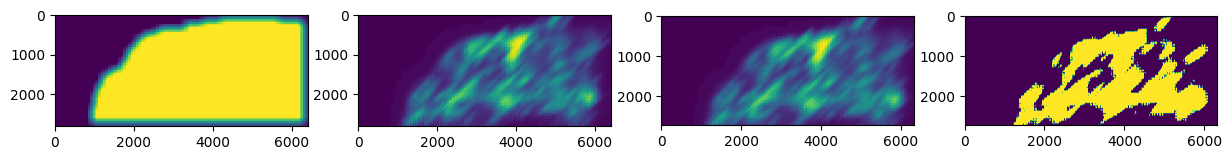

100%|██████████| 24/24 [00:01<00:00, 20.09it/s]


hello


/tmp/ipykernel_453742/2987970683.py:19: RuntimeWarning: invalid value encountered in cast
  predictions_map_counts = np.empty_like(predictions_map).astype(np.uint8)
100%|██████████| 156/156 [01:49<00:00,  1.43it/s]


locs (4990, 4)
preds (4990, 256, 256)
new_predictions_map (5632, 6400, 1)
predictions_map (5632, 6400, 2)
predictions_map_counts.shape (5632, 6400)


<Figure size 640x480 with 0 Axes>

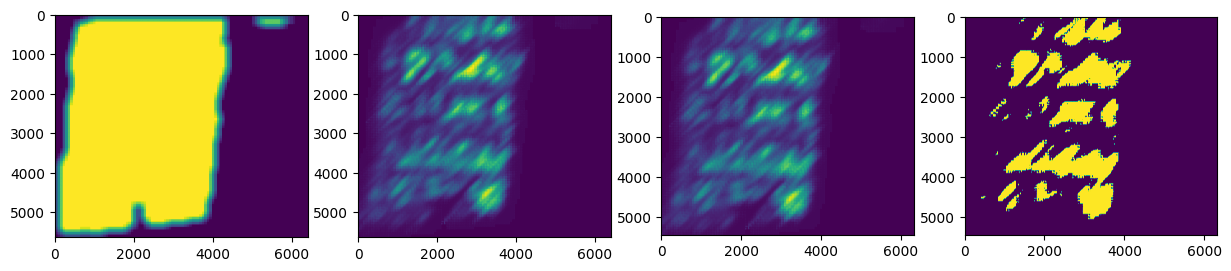

<Figure size 640x480 with 0 Axes>

In [113]:
results = []
for fragment_id in fragment_ids:
    if not in_submission:
        break
    test_loader, xyxys = make_dataset(fragment_id, is_train_data=False)
    
    binary_mask = cv2.imread(CFG.comp_dataset_path + f"{CFG.mode}/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)
    
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]

    pad0 = (CFG.prd_size - binary_mask.shape[0] % CFG.prd_size)
    pad1 = (CFG.prd_size - binary_mask.shape[1] % CFG.prd_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)

    predictions_map = np.empty_like(binary_mask)[:, :, np.newaxis].astype(np.float64)
    predictions_map_counts = np.empty_like(predictions_map).astype(np.uint8)

    model = CustomModel()
    model = nn.DataParallel(model)
    model.module.load_state_dict(
        torch.load(f"/home/fummicc1/codes/competitions/kaggle-ink-detection/weights/weights.pt"),
        # f"/kaggle/input/first-ink-detection/weights_fold-{fold}.ckpt",
    )
    model = model.cuda().eval()
    
    predict(model, test_loader)

    # trainer = pl.Trainer(
    #     accelerator="gpu",
    #     devices="1",
    #     max_epochs=CFG.epochs,
    #     logger=WandbLogger()
    # )

    # trainer.test(
    #     model=model,
    #     dataloaders=test_loader,
    #     verbose=True,
    # )

    
    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    
    # TODO: Kfold
    # predictions_mapやpredictions_map_countsは0番目のチャネルには適用な値が入っているので注意

    predictions_map = predictions_map[:, :, 1:].mean(axis=-1)
    predictions_map_counts = predictions_map_counts[:, :, 1:].mean(axis=-1)
    print("predictions_map_counts.shape", predictions_map_counts.shape)    

    axes[0].imshow(predictions_map_counts)
    axes[1].imshow(predictions_map)  

    mask_pred = predictions_map[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]

    axes[2].imshow(mask_pred)
    
    mask_pred = (mask_pred >= TH).astype(np.uint8)
    mask_pred=mask_pred.astype(int)
    mask_pred *= binary_mask
    
    axes[3].imshow(mask_pred)
    plt.show()
    
    inklabels_rle = rle(mask_pred)
    
    results.append((fragment_id, inklabels_rle))
    

    del predictions_map, predictions_map_counts
    del test_loader
    
    gc.collect()
    torch.cuda.empty_cache()
    plt.clf()
    plt.close(fig)

## submission

In [114]:
# ! cp /kaggle/input/vesuvius-challenge-ink-detection/sample_submission.csv submission.csv
# if in_submission:
#     sub = pd.DataFrame(results, columns=['Id', 'Predicted'])
#     #sub
#     sample_sub = pd.read_csv(CFG.comp_dataset_path + 'sample_submission.csv')
#     sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')
#     #sample_sub
#     sample_sub.to_csv("submission.csv", index=False)
#     print("ok")